# Notebook 4 of 4 - Modeling (Part II): Supervised Learning
**Code and Markdown Author:** _Boom Devahastin Na Ayudhya_

This is the final notebook that takes all our engineered features (including those from unsupervised approaches) and lessons learned from EDA to construct supervised learning models to predict our final outcome of whether a customer will open or still choose to keep a securities account by month end of May 2016 based on all features under consideration. We explore both parametric and non-parametric models here, but start simple and add complexity as needed.

We load the processed data that was generated at the end of Notebook 3 in this notebook for use. This is `mod_unsup_2.csv` in the [Shared Google Drive link](https://drive.google.com/drive/folders/19anLU9JuQ5DRRB38Ff5yzKcD4pRJi0i3?usp=sharing). 

## Section 0: Data Loading

Make sure you have the `mod_unsup_2.csv` file added to your Google Drive. You may need to modify the `pd.read_csv()` path line accordingly!

In [ ]:
# Import Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load proprocessing/modeling/evaluation libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# Miscellaneous
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')

In [ ]:
# Read cleaned df (modify filepath as needed if you are re-running this code from your Colab environment)
data = pd.read_csv('/content/drive/MyDrive/Shared CIS 545 Final Project/data/mod_unsup_2.csv')

# Peak
data.head()

,cust_code,age,new_cust,months_as_senior,diff_birth_country,deceased,province,active,income,securities_may,savings_acct_months,guarantees_months,cuurent_acct_months,derivada_acct_months,payroll_acct_months,junior_acct_months,max_particular_acct_months,particular_acct_months,particular_plus_acct_months,short_term_deposits_months,medium_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P,rel_type_A,is_male,province_actual_labels,segment_graduate_academic,segment_individual,segment_top,cluster_kmeans_0,cluster_kmeans_1,cluster_kmeans_2,cluster_kmeans_3
0,15902,58,0,255,0,0,0.037073,1,230408,0,0,0,17,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,MADRID,0,0,1,1,0,0,0
1,16232,54,0,253,0,0,0.037073,0,149565,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,MADRID,0,1,0,1,0,0,0
2,16274,60,0,253,0,0,0.037073,0,96276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,MADRID,0,1,0,1,0,0,0
3,16339,55,0,253,0,0,0.037073,1,197736,0,0,0,17,0,17,0,0,0,17,0,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,MADRID,0,0,1,0,0,0,1
4,16510,47,0,252,0,0,0.037069,1,213265,1,0,0,16,0,17,0,0,17,17,0,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,MADRID,0,0,1,0,0,0,1


## Section 1: Final Cleaning and Preprocessing

### Final Cleaning Tasks

From our EDA, we realized there were some instances and some features that can be reliably dropped.

#### Removing Deceased Customers

As seen in Section 2(g) of the EDA Part I notebook: it does not make sense to make forward-looking predictions on someone who is already dead, so we can remove customers (with their entire time series) who have been marked at `Deceased == 1` at any point in their time series.

In [ ]:
# Get customer IDs for only alive customers (where deceased = 0)
alive_customer_IDs = data[data['deceased'] == 0]['cust_code'].unique()

# Filter DF to only have time series of alive customers
data = data[data['cust_code'].isin(alive_customer_IDs)]

# Drop it
data = data.drop(columns = 'deceased')

#### Removing Lingering String Columns

In [ ]:
# Need to drop string column (initially thought trees could handle it in sklearn, but apparently not)
data = data.drop(columns = 'province_actual_labels')

### Baseline

We establish a baseline that always predicts the majority class to see how our models compare to.

In [ ]:
# Proportion of majority class in dataset
baseline_acc = data['securities_may'].value_counts(normalize = True).max()*100

print(f'Baseline Accuracy: {np.round(baseline_acc,2)}%')

Baseline Accuracy: 97.69%


Classes are highly imbalanced here. It doesn't make sense for us to predict accuracy, since it's unlikely we can beat a baseline this high. Simply predicting the majority class (i.e. no security account) will almost always beat a learned model.

As a result, we will resort to AUC ROC score instead.

### Train-Test Split with Undersampler

We should also deal with the class imbalance directly by undersampling the majority class (no securities). This is done after the usual train test split. 

Note that the dataset is large enough that we can do undersampling and not lose significant data. If we did oversampling the minority class, we would exceed 1 million rows and risk slowing Pandas down so we opted for the undersampling approach instead.

In [ ]:
# Create feature matrix (X) and target vector (y)
y = data['securities_may']
X = data.set_index("cust_code")
X = X.drop(columns = ["securities_may"])

In [ ]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify = y)

# How many negative and positive class instances for target?
print(f'Without under/oversampling, the distribution of negative to positive classes is {(sum(y_train==0), sum(y_train==1))}')

Without under/oversampling, the distribution of negative to positive classes is (631120, 14937)


In [ ]:
# Apply Random Under Sampling (rus)
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# How many negative and positive classes now?
print(f'After undersampling majority class, the distribution of negative to positive classes is now {(sum(y_train_rus==0), sum(y_train_rus==1))}')

After undersampling majority class, the distribution of negative to positive classes is now (14937, 14937)


### Standard Scaler

If we intend to use any regularization on parametric models such as L1/L2 regularization on Logistic Regression, we need to scale the data at the cost of losing precise interpretability of coefficients.

We create new variables though because we want to preserve regular unit for our scale invariant models.  

In [ ]:
# Instantiate Standard Scaler object
ss = StandardScaler()

# Learn mean and variance from train set
ss.fit(X_train_rus)

# Apply transformation
X_train_rus_sc = ss.transform(X_train_rus)
X_test_sc = ss.transform(X_test)

## Section 2: Modeling

Here we try a suite of classification models to see which one does best.

### Model 1(a): Logistic Regression (Vanilla Version)

While we anticipate this will be severely overfit with no hyperparameters to train, this is the most interpretable since coefficients of the regression will be with respect to the original features and the standard log cost loss function.

Again, the key here is to start with the simplest model and and complexity as needed.

In [ ]:
# Re-fit on whole training set and test
logit = LogisticRegression()
logit.fit(X_train_rus, y_train_rus)

# While we optimized for AUC ROC, we balanced classes so see how accuracy did just for kicks
print(f'The Training set Accuracy score is: {100*round(logit.score(X_train_rus, y_train_rus),2)}%')
print(f'The Testing set Accuracy score is: {100*round(logit.score(X_test, y_test),2)}%')

print('----------')

# Get AUC ROC score
print(f'The Training set AUC ROC score is: {round(roc_auc_score(logit.predict(X_train_rus), y_train_rus),4)}')
print(f'The Testing set AUC ROC score is: {round(roc_auc_score(logit.predict(X_test), y_test),4)}')

The Training set Accuracy score is: 74.0%
The Testing set Accuracy score is: 78.0%
----------
The Training set AUC ROC score is: 0.7448
The Testing set AUC ROC score is: 0.5311


**Observation:**
- Logistic Regression is severely overfit. The testing AUC ROC score is abysmal since it's so close to 0.5.
- We'll seek to improve this with regularization in Model 1(b).

In [ ]:
# Size the impact
pd.DataFrame({"coefficients": list(logit.coef_[0]),
              "exp(coef)": list(np.exp(list(logit.coef_[0])))},
             index = X_train_rus.columns).sort_values("coefficients", ascending = False)

,coefficients,exp(coef)
e_account_months,2.743499e-02,1.027815
direct_debit_months,2.635166e-02,1.026702
funds_months,1.684879e-02,1.016992
payroll_acct_months,1.605146e-02,1.016181
credit_card_months,1.558751e-02,1.015710
imputed_pensions_2_months,1.427190e-02,1.014374
months_since_first_contract,1.228804e-02,1.012364
imputed_payroll_months,1.169624e-02,1.011765
taxes_months,1.168240e-02,1.011751
particular_acct_months,1.164676e-02,1.011715


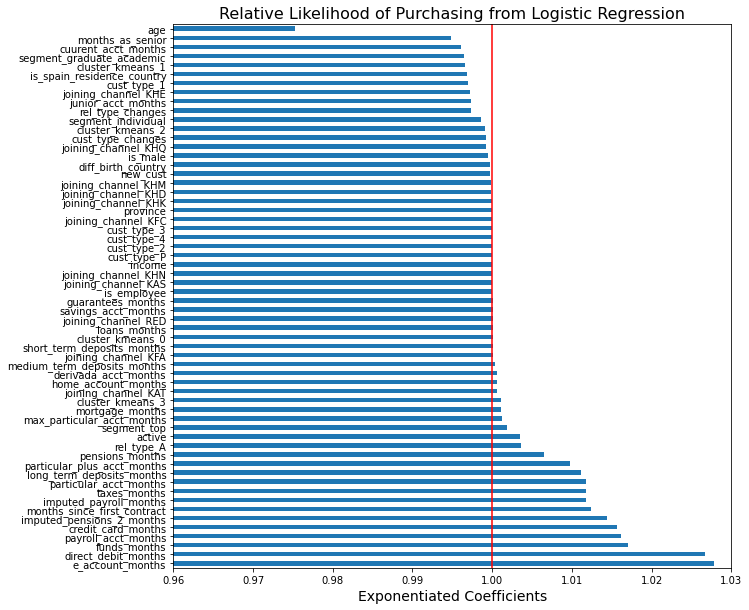

In [ ]:
# Visualize coefficients
coefs = pd.Series(list(np.exp(list(logit.coef_[0]))), index = X_train_rus.columns)
large_coefs = pd.concat([coefs.sort_values(ascending = False)])
plt.figure(figsize = (10,10))
large_coefs.plot(kind = "barh")
plt.title("Relative Likelihood of Purchasing from Logistic Regression", fontsize = 16)
plt.xlabel("Exponentiated Coefficients", fontsize = 14)
plt.xlim((0.96, 1.03))
plt.axvline(x=1.00, color = 'r')
plt.show()

**Observations:**
- The top 2 positive contributors were `e_account_months` and `direct_debit_months`.
- On the other hand, age goes the opposite direction and discourages opening a securities account.
- In terms of the k-means cluster features, there is no striking results here. All of the exponentiated coefficients are virtually 1.00 (which means there's no change in impact)
  - This is probably a consequence of the unclear number of clusters from the elbow plot we previously mentioned. We tried to pick the "best" elbow, but even that didn't cluster very well.

### Model 1(b): Logistic Regression (with Regularization)

We now try to curtail the overfitting by adding regularization. This means we do need to use the scaled versions of the features since regularization is not scale invariant, but at the cost of losing precise interpretion for sizing the impact on subscription probabilities.

We only have two types of regularization to use from `l1` (LASSO-based) or `l2` (Ridge-based), so we include both cases to search. As for regularization strength, we experiment is a variety of orders of magnitude to see how it performs.

In [ ]:
# Fit model on random understampled train set
grid_params_logit_reg = {"penalty":           ['l1', 'l2'],
                         "solver":            ['liblinear'],                         # l1 penalty doesn't work with default lbfgs solver
                         "C":                 [0.01, 0.1, 1, 10, 100]}

regularized_logit_randCV = RandomizedSearchCV(estimator = LogisticRegression(),
                            param_distributions = grid_params_logit_reg,
                            scoring = 'roc_auc')

regularized_logit_randCV.fit(X_train_rus_sc, y_train_rus);

In [ ]:
# Return best parameters
print("The optimal parameters are:", regularized_logit_randCV.best_params_)
print(f'The best mean cross validation score is {round(100*regularized_logit_randCV.best_score_,3)} %')

The optimal parameters are: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1}
The best mean cross validation score is 92.878%


In [ ]:
# Re-fit on whole training set and test using optimal parameters
regularized_logit = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1)
regularized_logit.fit(X_train_rus, y_train_rus)

# While we optimized for AUC ROC, we balanced classes so see how accuracy did just for kicks
print(f'The Training set Accuracy score is: {100*round(regularized_logit.score(X_train_rus, y_train_rus),2)}%')
print(f'The Testing set Accuracy score is: {100*round(regularized_logit.score(X_test, y_test),2)}%')

print('----------')

# Get AUC ROC score
print(f'The Training set AUC ROC score is: {round(roc_auc_score(regularized_logit.predict(X_train_rus), y_train_rus),4)}')
print(f'The Testing set AUC ROC score is: {round(roc_auc_score(regularized_logit.predict(X_test), y_test),4)}')

The Training set Accuracy score is: 87.0%
The Testing set Accuracy score is: 79.0%
----------
The Training set AUC ROC score is: 0.8785
The Testing set AUC ROC score is: 0.5474


**Observation:**
- Logistic Regression is still severely overfit even after removing correlated features and throwing L1 regularization.
- However, L1 regularization did improve the results slightly from the vanilla version.
- Let's see if a tuned Decision Tree Classifier will do better in terms of reducing overfitting.

### Model 2: Decision Tree Classifier

We move onto our first non-parametric model here. Note that we don't need to use the scaled versions of the training set here since tree models are scale invariance.

By setting a maximum depth of the tree and the minimum number of samples required to split a node, we impose two regularization hyperparameters.

Note that we included the `None` case for `max_depth` to control for one set of cases when we just impose just 1 type of regularization on `min_samples_split` so as to not regularize too much. The cross validation will figure out what the optimal combination is.

In [ ]:
# Validate to find optimal parameters
grid = {'max_depth': [10, 20, 30, 40, 50, None],
        'min_samples_split': [5, 50, 100, 125, 200]}

DT_randCV = RandomizedSearchCV(estimator = DecisionTreeClassifier(),
                               param_distributions = grid,
                               scoring = 'roc_auc')

DT_randCV.fit(X_train_rus, y_train_rus);

In [ ]:
# Return best parameters
print("The optimal parameters are:", DT_randCV.best_params_)
print(f'The best mean cross validation score is {round(100*DT_randCV.best_score_,3)} %')

The optimal parameters are: {'min_samples_split': 200, 'max_depth': None}
The best mean cross validation score is 99.141 %


In [ ]:
# Re-fit on whole training set and test
DT_clf = DecisionTreeClassifier(min_samples_split = 200, max_depth = None)
DT_clf.fit(X_train_rus, y_train_rus)

# While we optimized for AUC ROC, we balanced classes so see how accuracy did just for kicks
print(f'The Training set Accuracy score is: {100*round(DT_clf.score(X_train_rus, y_train_rus),2)}%')
print(f'The Testing set Accuracy score is: {100*round(DT_clf.score(X_test, y_test),2)}%')

print('----------')

# Get AUC ROC score
print(f'The Training set AUC ROC score is: {round(roc_auc_score(DT_clf.predict(X_train_rus), y_train_rus),4)}')
print(f'The Testing set AUC ROC score is: {round(roc_auc_score(DT_clf.predict(X_test), y_test),4)}')

The Training set Accuracy score is: 96.0%
The Testing set Accuracy score is: 96.0%
----------
The Training set AUC ROC score is: 0.9628
The Testing set AUC ROC score is: 0.6678


**Observation:**
- Regularized Decision Tree Classifier did amazingly well!
- In terms of Accuracy, it is doing well (strangely even though we optimized for roc_auc in the grid search)
- AUC score suggests overfitting, but both train and test scores higher than Logistic Regression with regularization.
- Let's see if we can further reduce overfitting with Random Forests.

### Model 3: Random Forest

Non-parametric scale invariant models seem to do well. But we can take that even further by using ensemble models to tone down the variance.

The hyperparameters we fit here are similar to the tree, but we now include one for the number of estimators (i.e. trees in the forest) as well and also set a maximum number of feature considered in the step where a random subset of features is considered for the split. We keep this number low as we need to regularize more.

_**WARNING:** This will take a VERY long time to train (4-8 hours if I recall), so be careful about running this. You may experience slowed processes if doing other things with your computer while grading!_

In [ ]:
# Validate to find optimal parameters
grid = {'n_estimators': [10, 25, 50, 75, 80, 100, 150, 200, 250, 500, 1000],
        'max_features': [1, 2, 3, 4],
        'min_samples_split': [2, 3, 5, 8, 10, 15, 20, 25, 50, 80, 100, 125, 200]}

RF_randCV = RandomizedSearchCV(estimator = RandomForestClassifier(),
                               param_distributions = grid,
                               scoring = 'roc_auc')

RF_randCV.fit(X_train_rus, y_train_rus);

In [ ]:
# Return best parameters
print("The optimal parameters are:", RF_randCV.best_params_)
print(f'The best mean cross validation AUC ROC score is {round(100*RF_randCV.best_score_,3)} %')

The optimal parameters are: {'n_estimators': 1000, 'min_samples_split': 15, 'max_features': 4}
The best mean cross validation AUC ROC score is 97.741 %


In [ ]:
# Re-fit on whole training set and test
RF = RandomForestClassifier(max_features= 4, min_samples_split = 15, n_estimators = 1000)
RF.fit(X_train_rus, y_train_rus)

# While we optimized for AUC ROC, we balanced classes so see how accuracy did just for kicks
print(f'The Training set Accuracy score is: {100*round(RF.score(X_train_rus, y_train_rus),2)}%')
print(f'The Testing set Accuracy score is: {100*round(RF.score(X_test, y_test),2)}%')

print('----------')

# Get AUC ROC score
print(f'The Training set AUC ROC score is: {round(roc_auc_score(RF.predict(X_train_rus), y_train_rus),4)}')
print(f'The Testing set AUC ROC score is: {round(roc_auc_score(RF.predict(X_test), y_test),4)}')

The Training set Accuracy score is: 96.4%
The Testing set Accuracy score is: 96.2%
----------
The Training set AUC ROC score is: 0.9456
The Testing set AUC ROC score is: 0.7044


**Observation:**
- Random Forest classifier decreased the amount of overfitting so it did it's job.
- However, there is still quite a bit of overfitting here. The hyperparameters need to be further finetuned since RandomizedSearchCV may not have found the optimal combination. Even so, that took far too long to train so we are unfortunately out of time.

## Final Conclusions: Key Takeaways and Further Enquiry

After extensive data cleaning of this massive dataset using Amazon S3 and Apache Spark, we've managed to conduct a deep exploratory data analysis of each of the features. As observations led to more questions and deeper dives, all of this gave us insight into how to engineer new features that captured inherent signals such as potential "volatiity" (hence risk appetite) and customer loyalty (via tenure). By engineering a stock-based metric for age of each account type, we were able to collapse the superfluous flow of the time series down to convert this from a panel data problem to a cross sectional data problem, makng analysis more tractable and allowing use of our standard ML models.

Since we were dealing with unbalanced classes, we needed to undersample from the majority class. We also tried looking at AUC ROC score instead of accuracy and optimized for the former in any GridSearchCV or RandomizedCV.

Our supervised modeling approach was to start simple and add complexity as needed. Hence, we started simple by building a vanilla Logistic Regression (i.e. without regularization and hyper parameter tuning) and had a severely overfit model as expected.

However, this was our most interpretable model where we could size the direction and impact of the features by interpreting exponentiated coefficients ($e^{\beta_{j}}$). We found that the top 2 positive contributors were `e_account_months` and `direct_debit_months`. It was suspicious to see `direct_debit_months` since this is bound to be an account everyone has. However, opening `e_accounts` for longer had the largest (though still small) positive impact on whether a user opens a security account. Since this is an interpretable model, we can reason that if a user holds an `e_account` for one more additional month, the customer is $(1.027815 - 1)\times 100 = 2.78\\%$ **more** likely to open/have a security account in May 2016. On the other hand, age goes the opposite direction and discourages opening a securities account. The exponentiated coefficient suggests that for an additional increase in years of age, the user will be $(0.975230 - 1) \times 100 = -2.48\%$ **less** likely to open a security account.

This was in line with expectations given that older individuals tend to be more risk-averse and therefore less likely to invest in securities. More information on occupation or other signals for financial savvyness would have been ideal for digging deeper, but not in this dataset but useful to consider for Further Enquiry.

In terms of the features generated by our unsupervised learning algorithms, sadly they did not really contribute much. Nevertheless, it was useful to visualize potential segments customers could have been grouped into.

Pivoting in the direction of getting the best predictive model possible at the cost of interpretability, our models showed increasingly promising results with each successive incarnation. We next did regularization on the Logistic Regression which reduced overfitting slightly, but still had much room for improvement. Switching over to non-parametric and scale invariant tree based models ended up being a good call as the tuned Decision Tree Classifier did substantially better. Ultimately, our final Random Forest did the best trading a little bit of the training score to shrink the overfitting gap for a slightly better testing AUC ROC score of about 0.70. This achieved our goal of further reducing overfitting and produced quite a robust model.